# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import scipy.ndimage.filters

from copy import deepcopy
from math import ceil

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    

def spectog(x,w,R=1, M=32, Nw=31, Nt=10,affich=True):
    Xtilde = np.zeros((M,Nt),dtype=complex)
    for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
        deb = u * R + 1 # début de trame
        fin = deb + Nw # fin de trame
        tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
        X = np.fft.fft(tx,M) # tfd à l'instant b
        if affich:
            Xtilde[:,u] = X
        # opérations de transformation (sur la partie \nu > 0)
        # ....
        Y = X.copy
        # fin des opérations de transformation
        # resynthèse
        # overlap add
    return Xtilde
   

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [5]:
play = False
if play :
    play_sound(sound) 

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [7]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

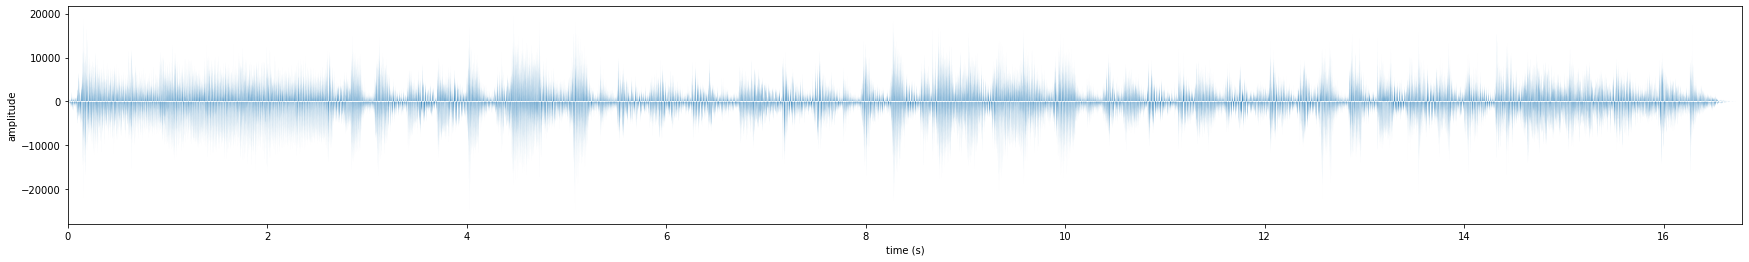

In [8]:
plot_sound(x, times)

# 2. Resampling
## 2.1

INSERT BLOCK DIAGRAM

The resampling process consist firsly of upsampling the original signal (sampled at $fs$) by L, and then downsampling by M. The result is a signal sampled at $fs*\frac{L}{M}$. In order to do the upsampling operation, we first pad the signal with 0s to reach the desired frequency $fs*L$, and then apply a lowpass filter to remove the spectral content that is now present after frequency $\frac{fs}{L}$. Similarly, in order to downsample the signal sampled at $fs$ we first apply a lowpass filter to remove the spectral content above frequency $\frac{fs}{2M}$, and then keep only one every M samples.

The same filter can be used for both upsampling and downsampling operations: one simply needs to use the filter with lowest cut frequency

## 2.2
### Filter design
Obtain lowpass filter coeficients using remez method. The ideal cut frequency is $\frac{1}{6}$, of 96 kHz which corresponds to 16 kHz. To apply the upsampling, a cut frequency of at most 24 khz is needed, while the downsampling requires 16 kHz. Therefore, in order to use the same filter for both operations, the min{16 kHz, 24 kHz} must be chosen.

In [9]:
h = scipy.signal.remez(100,[0,1/6,1/6+1/10,0.5],[1,0])
H = np.abs(np.fft.fft(h))

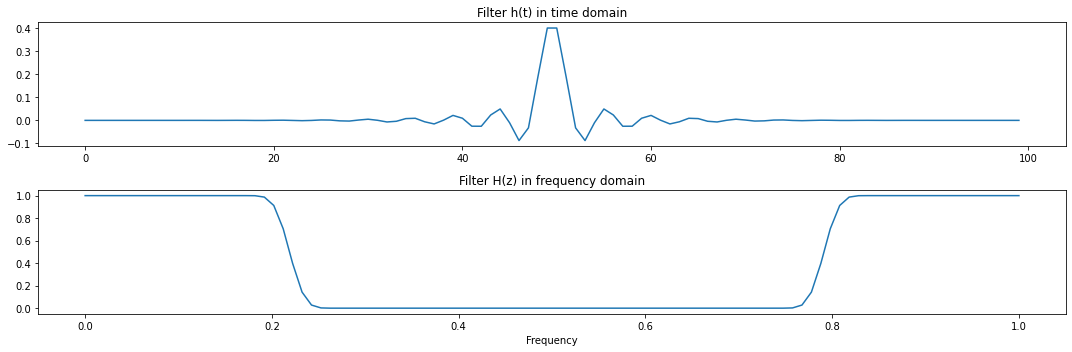

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(h)
plt.title('Filter h(t) in time domain')
plt.subplot(2,1,2)
plt.plot(np.linspace(0,1,len(H)),H)
plt.title('Filter H(z) in frequency domain')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

### Zero padding (upsampling)

In [11]:
zero = np.zeros(len(x)*2)
x2 = zero
for i in np.arange(0,len(x)):
    x2[i*2] = x[i]
    

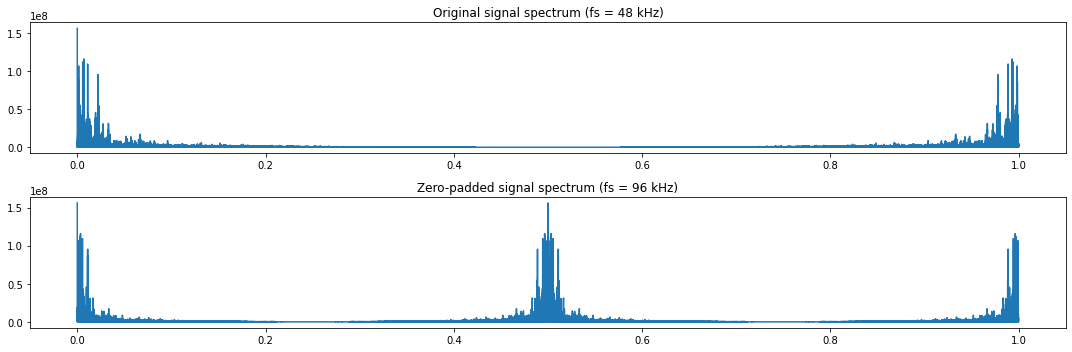

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(np.linspace(0,1,len(x)),np.abs(np.fft.fft(x)))
plt.title('Original signal spectrum (fs = 48 kHz)')
plt.subplot(2,1,2)
plt.plot(np.linspace(0,1,len(x2)),np.abs(np.fft.fft(x2)))
plt.title('Zero-padded signal spectrum (fs = 96 kHz)')
plt.tight_layout()

plt.show()

### Applying Filter h (interpolation)

In [13]:
x_filtered = scipy.ndimage.filters.convolve(x2,h)

In [14]:
np.size(h)

100

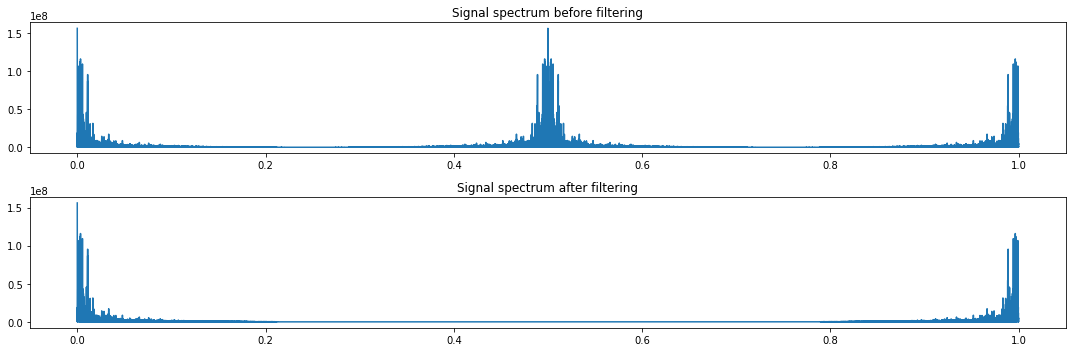

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(np.linspace(0,1,len(x2)),np.abs(np.fft.fft(x2)))
plt.title('Signal spectrum before filtering')
plt.subplot(2,1,2)
plt.plot(np.linspace(0,1,len(x_filtered)),np.abs(np.fft.fft(x_filtered)))
plt.title('Signal spectrum after filtering')
plt.tight_layout()
plt.show()

### Removing samples (downsampling)

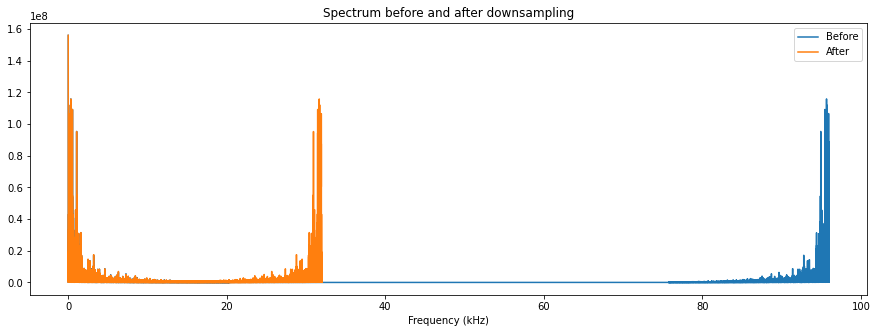

In [16]:
y = x_filtered[::3]*3

plt.figure(figsize=(15,5))
plt.plot(np.linspace(0,96,len(x_filtered)),np.abs(np.fft.fft(x_filtered)))
plt.plot(np.linspace(0,32,len(y)),np.abs(np.fft.fft(y)))
plt.xlabel('Frequency (kHz)')
plt.title('Spectrum before and after downsampling')
plt.legend(['Before', 'After'])
plt.show()

### Save resampled singnal to file '36kHz.wav' 

In [17]:
from scipy.io.wavfile import write
write('36kHz',32000,np.array(y,dtype=np.int16))

## 2.3

## 2.4

## 2.5
### Comparison of the two approaches

# STFT audio equalization
## 3.1 Signal analysis with the STFT

In [18]:
N = x.shape[0] # % longueur du signal
Nw = 31
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 1024 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

### a) DFT of Hanning window
 The width of the main lobe is $\frac{4}{N_w}$, where $N_w$ is the window size

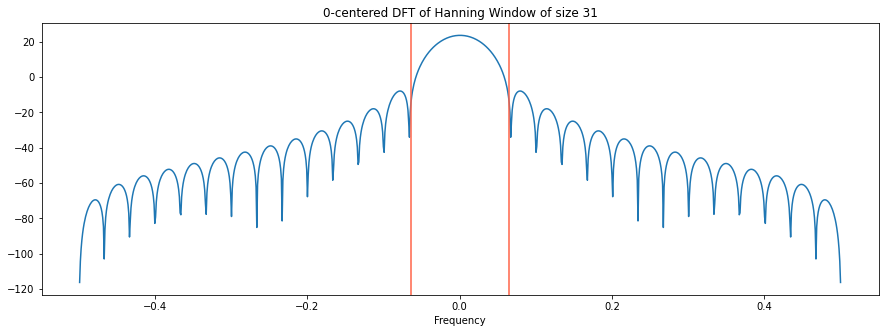

In [19]:
A = np.fft.fft(w, M)
mag = np.abs(np.fft.fftshift(A))    # Shifts fft 

freq = np.linspace(-0.5, 0.5, len(A))   #Frequency values

with np.errstate(divide='ignore', invalid='ignore'):
    response = 20 * np.log10(mag)

plt.figure(figsize=(15,5))
plt.plot(freq, response)
plt.axvline(x=2/Nw, ymin=0, ymax=1,c='tomato')
plt.axvline(x=-2/Nw, ymin=0, ymax=1,c='tomato')
plt.xlabel('Frequency')
plt.title('0-centered DFT of Hanning Window of size '+ str(Nw))

# Plots window in time domain
#plt.figure(figsize=(15,5))
#plt.plot(w)
plt.show()

### b)
For a given $\lambda$ (frequency) the equation 

\begin{equation}
W_x(\lambda,b) = \sum_{n\in\mathbb{Z}}^{} x(n)w(n-b)e^{-j2\pi \lambda n},
\end{equation} 
 can be seen as the convolution of the window w(n) with the signal x(n) which has been modulated by the exponential $e^{-j2\pi \lambda n}$. Therefore, in the frequency domain, the spectrum of x(n) is shifted by $\lambda$ and then filtered by the lowpass filter W(z). The lowpass filter extracts the $\lambda$ frequency component from a given window in the input signal x(n).
 
Since the filter has an odd length and is symmetric, it is a type I FIR filter.

### c)

The convention used in this notebook is the "band-pass convention". 

\begin{equation}
\widetilde{X}(\lambda,b) = \sum_{n\in\mathbb{Z}}^{} x(n+b)w(n)e^{-j2\pi \lambda n},
\end{equation} 

Similarly to the "low-pass convention", the exponential component in the equation modulates a signal, this time the window w. In the frequency domain, the spectrum of $w(n)$ is shifted by $\lambda$, which acts as a band-pass filter, filtering the signal $x(n)$ at frequency $\lambda$ . The filtering operation is the result of the convolution, in the time domain, between $x(n)$ and $w(n)e^{-j2\pi \lambda n}$




### d)
Computing signal $x_k(u)$ =$\widetilde{X}(k,u)$ for k=3 and writing the result to audio file '3d.wav'. The signal is complex, therefore it is necessary to extract the real component.

In [20]:
# Sets up parameters
k=3        # Frequency channel
Nw = 31
M=32
R=1
Nt = np.rint((N - Nw)/R)
Nt = Nt.astype(int)
w = np.hanning(Nw) #
ws = w.copy; 
L = M/2+1

# Calculates the spectogram Xtilde
Xtilde1 = spectog(x, w, R=R,M=M,Nw=Nw,Nt=Nt)
# Evaluates at frequency channel k
xk = Xtilde1[k,:]
rexk = np.real(xk)

write('3d',48000,np.array(rexk,dtype=np.int16))

<ipython-input-21-3edbcc523a69>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, 20*np.log10(Sxx))


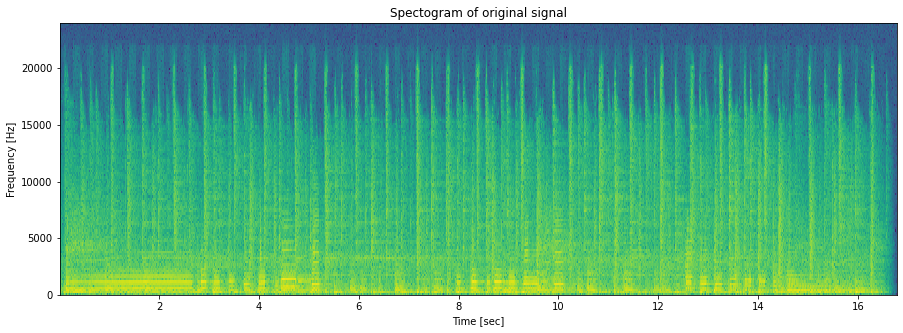

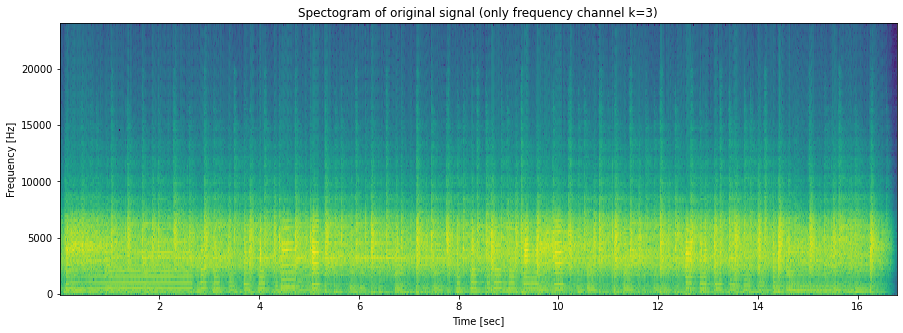

In [21]:
plt.figure(figsize=(15,5))

f, t, Sxx = scipy.signal.spectrogram(x, 48000)
plt.pcolormesh(t, f, 20*np.log10(Sxx))
plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')
plt.title('Spectogram of original signal')
plt.show()

plt.figure(figsize=(15,5))
f, t, Sxx = scipy.signal.spectrogram(rexk, 48000)

plt.pcolormesh(t, f, 20*np.log10(Sxx), shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectogram of original signal (only frequency channel k=3)')
plt.show()



### Comparison with butterworth filter 
fc = 4500 Hz, equivalent to frequency channel k = 3 in the STFT

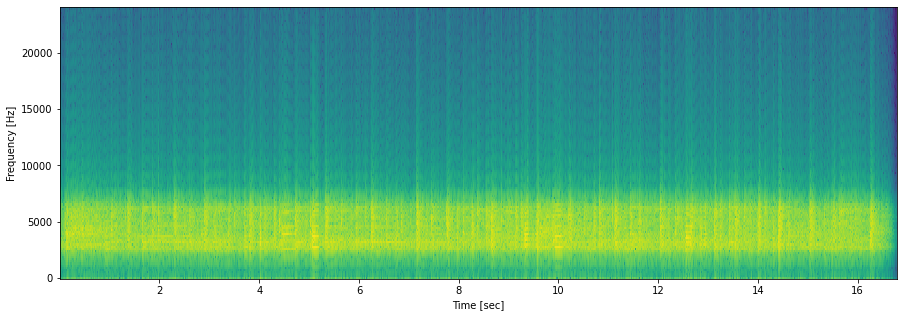

In [22]:
f_desired = 4500
f_total = 48000
Nw_form = 31
b_coef, a_coef = scipy.signal.butter(9, [2*f_desired/f_total-2.5/(Nw_form), 2*f_desired/f_total+2.5/(Nw_form)], btype='band')
y = scipy.signal.filtfilt(b_coef, a_coef, x)
write('4d.wav',48000,np.array(y,dtype=np.int16))

plt.figure(figsize=(15,5))
f, t, Sxx = scipy.signal.spectrogram(y, 48000)

plt.pcolormesh(t, f, 20*np.log10(Sxx), shading='auto')

plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')

plt.show()

## 3.2 Reconstruction

### e)

In [23]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

In [24]:
a = ola(w=w, hop=int(len(w)/4), Nb=10)

### f)

Defining reconstruction function

In [25]:
def reconst(xtilde,w,R=1, M=32, Nw=31, N=1):
    X = np.zeros(N)
    for b in np.arange(0,xtilde.shape[1]):
        
        deb = R*b + 1 # début de trame
        fin = deb + Nw # fin de trame
        
        bx = xtilde[:,b]
        inv = np.fft.ifft(bx)
        
        tx = np.multiply(inv[:Nw],w)
        
        
        X[np.arange(deb.astype(int),fin.astype(int))] = X[np.arange(deb.astype(int),fin.astype(int))] + tx
        

    return X

In [26]:
# Sets up parameters
Nw = 31
M=32
R=7
Nt = np.rint((N - Nw)/R)
Nt = Nt.astype(int)
w = np.hanning(Nw) #
ws = w.copy; 
L = M/2+1

# Calculates the spectogram Xtilde2
Xtilde2 = spectog(x, w, R=R,M=M,Nw=Nw,Nt=Nt)

In [27]:
# Applies reconstruction
X = reconst(Xtilde2, w, R=R, M=M, Nw=Nw,N=N)

write('Reconstructec.wav',48000,np.array(X,dtype=np.int16))

<ipython-input-25-05aca4e490bd>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  X[np.arange(deb.astype(int),fin.astype(int))] = X[np.arange(deb.astype(int),fin.astype(int))] + tx


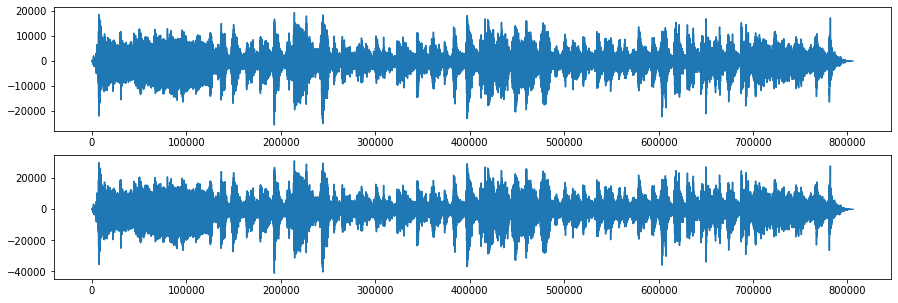

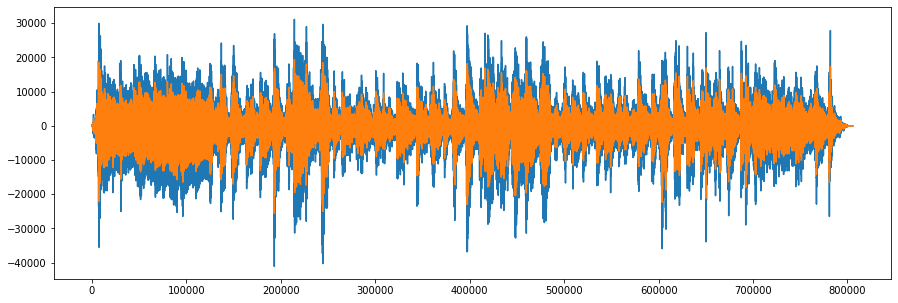

0.622226711532389

In [28]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(x)
plt.subplot(2,1,2)
plt.plot(X)

#X = X* max(x)/max(X)

plt.figure(figsize=(15,5))
plt.plot(X)
plt.plot(x)
plt.show()
np.sum(x)/np.sum(X)

## 3.3 STFT audio equalizer
### g)
Defines equalizer function and declares weight vector for the $\frac{M}{2}+1$ channels. 

In [29]:

def equalizer(xtilde, weights):
    a = xtilde.copy()
    for k in np.arange(0, int(xtilde.shape[0]/2)+1):
        a[k,:] = xtilde[k,:]*weights[k]
    return a

In [46]:
weights = np.ones(int(M/2)+1)

weights[7:-1]=0
weights[10]=0
weights[11]=0
weights[12]=0
weights[13]=0
weights[14]=0


b = np.real(Xtilde2).copy()
Y = equalizer(b,weights)

Y2 = reconst(Y, w, R=R, M=M, Nw=Nw,N=N)
Y2 = Y2 * max(x)/max(Y2)

write('equalizer.wav',48000,np.array(Y2,dtype=np.int16))

<ipython-input-25-05aca4e490bd>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  X[np.arange(deb.astype(int),fin.astype(int))] = X[np.arange(deb.astype(int),fin.astype(int))] + tx


954.7759601248197

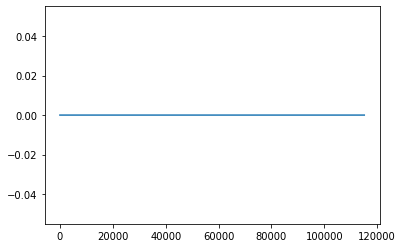

In [44]:
plt.plot(Y[7,:])
Y[5][1000]

<ipython-input-38-c2fb5c32002c>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, 20*np.log10(Sxx))


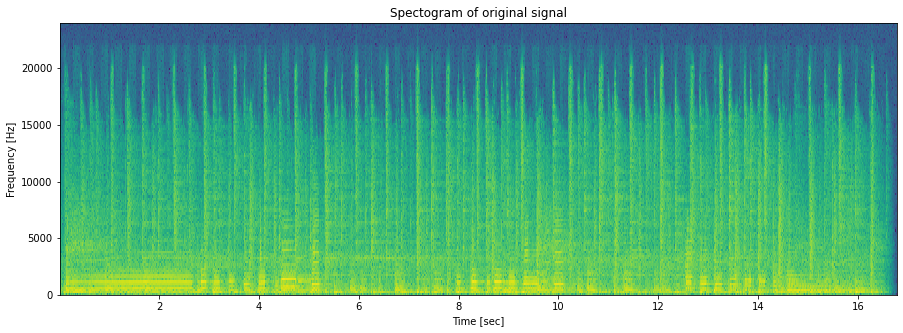

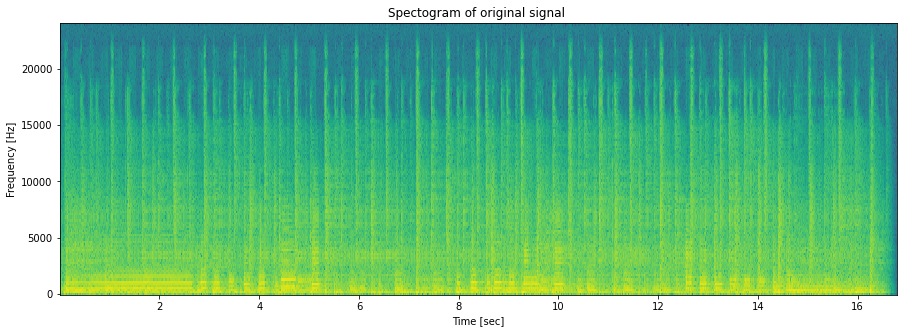

In [38]:
plt.figure(figsize=(15,5))

f, t, Sxx = scipy.signal.spectrogram(x, 48000)
plt.pcolormesh(t, f, 20*np.log10(Sxx))
plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')
plt.title('Spectogram of original signal')
plt.show()

plt.figure(figsize=(15,5))
f, t, Sxx = scipy.signal.spectrogram(Y2, 48000)

plt.pcolormesh(t, f, 20*np.log10(Sxx), shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectogram of original signal ')
plt.show()